# **Deep Learning Theory and Application** Assignment 2
# Coding Exercise on Contrastive Learning

### Name:
### NetID:


## Overview

As we have mentioned in class, contrastive learning is a self-supervised learning method such that the model organizes the latent space by comparing and contrastive data samples. In this exercise, we will walk through an example of utilizing contrastive learning for image classification.

## Scenario
We will use the CIFAR-10 dataset for this exercise. As you might recall, there are 50,000 training images and 10,000 testing images in this dataset. However, we will pretend that out of the 50,000 training images, only 100 are actually labeled. We will work with the **hypothetical** case, where we have 100 labeled images and 49,900 unlabeled images.

## Method
Which contrastive learning method shall we use? We will be using [SimCLR](https://arxiv.org/abs/2002.05709).


<div>
<img src="https://camo.githubusercontent.com/35af3432fbe91c56a934b5ee58931b4848ab35043830c9dd6f08fa41e6eadbe7/68747470733a2f2f312e62702e626c6f6773706f742e636f6d2f2d2d764834504b704539596f2f586f3461324259657276492f414141414141414146704d2f766146447750584f79416f6b4143385868383532447a4f67457332324e68625877434c63424741735948512f73313630302f696d616765342e676966" width="600"/>
</div>

## Goal
After we partition the data, we will experiment under 2 settings:

1. Fully supervised learning with 100 labeled training images.

2. Contrastive learning on 49,900 unlabeled training images + supervised fine-tuning on 100 training images.

Please fill in the TODO items, run the experiments, and report the testing accuracy under these 2 settings.

## 1. Download the CIFAR-10 dataset.

In [ ]:
import numpy as np
import torch
import torchvision

train_set = torchvision.datasets.CIFAR10('./datasets',
                                         train=True,
                                         download=True,
                                         transform=None)

test_set = torchvision.datasets.CIFAR10('./datasets',
                                        train=False,
                                        download=True,
                                        transform=None)

Files already downloaded and verified
Files already downloaded and verified


## 2. Prepare the "hypothetical training set".

In [ ]:
# Verify that there are 10 classes in the training set.
train_set_labels = np.array([img_label[1] for img_label in train_set])
np.unique(train_set_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# Randomly pick 10 data samples from each class --> 100 samples in total.
num_samples_per_class = 10

labeled_indices = []
for cls_id in np.unique(train_set_labels):
    valid_indices_arr = np.argwhere(train_set_labels == cls_id).flatten()
    selected_indices = np.random.choice(valid_indices_arr, num_samples_per_class, replace=False)
    labeled_indices.extend(selected_indices)

# Verify the length is correct.
assert len(labeled_indices) == 100

# Verify it is all unique.
assert len(np.unique(labeled_indices)) == 100

# The remaining 49,000 are the "unlabeled training data".
unlabeled_indices = list(set(np.arange(len(train_set_labels))) - set(labeled_indices))
assert len(unlabeled_indices) == 49900

In [ ]:
# Partition the training data into the "unlabeled set" and "labeled set".

from torch.utils.data import Dataset

class CIFAR10Subset(Dataset):
    def __init__(self, full_set, indices, is_labeled):
        super().__init__()
        self.full_set = full_set
        self.indices = indices
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data_sample = self.full_set[self.indices[idx]]

        if self.is_labeled:
            # Return both the image and the label.
            return data_sample
        else:
            # Return the image only.
            return data_sample[0]


train_set_unlabeled = CIFAR10Subset(train_set, unlabeled_indices, is_labeled=False)
train_set_labeled = CIFAR10Subset(train_set, labeled_indices, is_labeled=True)

In [ ]:
len(train_set_unlabeled), len(train_set_labeled)

(49900, 100)

## 3. Write a **Transforms** module for SimCLR contrastive learning.

Since we use the SimCLR method, we will follow the "single-instance multi-view" paradigm (with n_views = 2).

This means, for each input image, we will create 2 augmented versions of it.

Then, during the contrastive learning phase, the 2 augmented versions of the same image are considered a positive sample of each other.

In [ ]:
from typing import Tuple
import random
from PIL import ImageFilter
import torchvision.transforms as tfs


# This essentially serves as a TorchVision Transforms module
# even though not directly inheriting from it.
class SingleInstanceTwoView:

    def __init__(self, imsize: int, mean: Tuple[float], std: Tuple[float]):
        # TODO: The augmentation here includes the following components.
        # 1. Resize to `imsize`.
        # 2. Random Resized Crop with scale (0.8, 1.2) and output size of `imsize`.
        # 3. Random Horizontal Flip with probability 0.5.
        # 4. Random Apply Color Jitter with brightness 0.4, contrast 0.4, saturation 0.4, hue 0.1, at probability 0.4.
        # 5. Random Grayscale at probability 0.2
        # 6. Random Apply Gaussian Blur at probability 0.5.
        # 7. ToTensor: which converts it to floating point numbers.
        # 8. Normalize by the given mean and std.
        self.augmentation = tfs.Compose([

        ])

    def __call__(self, x):
        aug1 = self.augmentation(x)
        aug2 = self.augmentation(x)
        return aug1, aug2


class GaussianBlur(object):

    def __init__(self, sigma=[0.1, 1.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

### Use a Dataset Wrapper to include the **Transforms**.

In [ ]:
from typing import Iterable


class TransformsWrapper(Dataset):
    def __init__(self, dataset, transforms):
        super().__init__()
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.transforms is None:
            return self.dataset[idx]
        else:
            if isinstance(self.dataset[idx], Iterable):
                assert len(self.dataset[idx]) == 2
                return self.transforms(self.dataset[idx][0]), self.dataset[idx][1]
            else:
                return self.transforms(self.dataset[idx])


desired_image_size = (32, 32)
train_set_mean = (0.4914, 0.4822, 0.4465)  # train_set.data.mean(axis=(0, 1, 2)) / 255
train_set_std = (0.2470, 0.2435, 0.2616)  # train_set.data.std(axis=(0, 1, 2)) / 255

transform_supervised_train = tfs.Compose([
    tfs.Resize(desired_image_size,
               interpolation=tfs.InterpolationMode.BICUBIC),
    tfs.RandomResizedCrop(desired_image_size,
                          scale=(0.8, 1.2),
                          interpolation=tfs.InterpolationMode.BICUBIC),
    tfs.RandomHorizontalFlip(p=0.5),
    tfs.ToTensor(),
    tfs.Normalize(mean=train_set_mean, std=train_set_std)
])

transform_simclr_train = SingleInstanceTwoView(desired_image_size, mean=train_set_mean, std=train_set_std)

transform_test = tfs.Compose([
    tfs.Resize(desired_image_size,
              interpolation=tfs.InterpolationMode.BICUBIC),
    tfs.CenterCrop(desired_image_size),
    tfs.ToTensor(),
    tfs.Normalize(mean=train_set_mean, std=train_set_std)
])


train_set_labeled_final = TransformsWrapper(train_set_labeled, transform_supervised_train)
train_set_unlabeled_final = TransformsWrapper(train_set_unlabeled, transform_simclr_train)
test_set_final = TransformsWrapper(test_set, transform_test)

## 4. Write the loss function for SimCLR contrastive learning.

In [ ]:
from sklearn.metrics import accuracy_score


class InfoNCELoss(torch.nn.Module):
    '''
    Implement the InfoNCE loss.
    This is Equation 1 in the SimCLR paper https://arxiv.org/abs/2002.05709

    For the two batched vectors z1 and z2,
    z1: B x D
    z2: B x D
    They are both a batch of N latent vectors, such that
    each matching index forms a positive pair,
    while any unmatching index forms a negative pair.
        (z1[i], z2[j]) is positive, if i == j
        (z1[i], z2[j]) is negative, if i != j
        (z1[i], z1[j]) is negative, if i != j
        (z2[i], z2[j]) is negative, if i != j
    1. We will construct a matrix z by concatenating z1 and z2.
    2. We will take its self matrix muliplication after L2 normalization
       to form a 2B x 2B cosine similarity matrix.
    3. We perform the exp and 1/temperature right after, since these are commutative.
    4. Then we identify the locations corresponding to the positive pairs and negative pairs,
       and compute `score_pos` and `score_neg`.
    5. Finally, we compute the InfoNCE loss with these values.


    NOTE: Additional explanation on the formulation and masking.

    Suppose we have
    z1 = [z1aa z1ab z1ac      <---- z1a
          z1ba z1bb z1bc]     <---- z1b
    z2 = [z2aa z2ab z2ac      <---- z2a
          z2ba z2bb z2bc]     <---- z2b

    z = torch.cat((z1, z2), dim=0)
    z = [z1aa z1ab z1ac
         z1ba z1bb z1bc
         z2aa z2ab z2ac
         z2ba z2bb z2bc]

    Let's then look at torch.matmul(z, z.T). It will be 2B x 2B in shape.
    If we use A*B to denote torch.matmul(A, B), the resulting matrix will be:

    [z1a*z1a z1a*z1b z1a*z2a z1a*z2b
     z1b*z1a z1b*z1b z1b*z2a z1b*z2b
     z2a*z1a z2a*z1b z2a*z2a z2a*z2b
     z2b*z1a z2b*z1b z2b*z2a z2b*z2b]

    Positive pairs are: (z1a, z2a) and (z1b, z2b)
    Negative pairs are everything besides positive pairs or self-self pairs.

    Positive mask will be
    [F F T F
     F F F T
     T F F F
     F T F F]
    Negative mask will be
    [F T F T
     T F T F
     F T F T
     T F T F]

    Think carefully why this is the case, and how this principle extends to other values of B.
    '''

    def __init__(self, temperature: float = 0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1: torch.Tensor, z2: torch.Tensor):
        assert z1.shape == z2.shape
        B, _ = z1.shape

        z1 = torch.nn.functional.normalize(input=z1, p=2, dim=1)
        z2 = torch.nn.functional.normalize(input=z2, p=2, dim=1)
        z = torch.cat((z1, z2), dim=0)

        # Compute similarity matrix
        # Note that we refactor the `exp` and `1/temperature` operations here.
        sim_matrix = torch.exp(torch.matmul(z, z.T) / self.temperature)

        # TODO: Construct the positive mask and negative mask.
        positive_mask =
        negative_mask =

        # Selecting the positive examples for each anchor
        score_pos = sim_matrix[positive_mask].view(2 * B, 1)

        # Sum of all similarities for negative pairs
        score_neg = sim_matrix[negative_mask].view(2 * B, -1).sum(dim=1, keepdim=True)

        # Calculating the InfoNCE loss as the log ratio
        loss = -torch.log(score_pos / (score_pos + score_neg))

        # NOTE: The pseudo-accuracy computation is not necessary for this loss. It's just for sanity checking.
        true_mask = torch.eye(B, dtype=torch.bool)
        sim_z1_z2 = torch.matmul(z1, z2.T)

        pseudo_acc = accuracy_score(
            y_true=true_mask.cpu().detach().numpy().reshape(-1),
            y_pred=sim_z1_z2.cpu().detach().numpy().reshape(-1) > 0)

        return loss.mean(), pseudo_acc

## 5. Build the model.

This model can be used for both contrastive learning and supervised learning.

In [ ]:
import torch.nn as nn


class ConvNet(nn.Module):

    def __init__(self, in_channels=3, num_classes=10,
                 simclr_hidden_dim=256, simclr_z_dim=128):
        super().__init__()

        # Use ResNet18 as the base model.
        # Remove some pooling operations because the input images are small.
        self.encoder = []
        for name, module in torchvision.models.resnet18(
                num_classes=num_classes,
                weights=None).named_children():
            if name == 'conv1':
                module = torch.nn.Conv2d(3,
                                         64,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1,
                                         bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.encoder.append(module)
        self.encoder.append(nn.Flatten())
        self.encoder = torch.nn.Sequential(*self.encoder)

        encoder_out_dim = 512

        # TODO: build the linear projector.
        # The linear projector has the following components.
        # 1. a Linear layer mapping from `encoder_out_dim` to `simclr_hidden_dim`, with bias set to False.
        # 2. a BatchNorm1d layer.
        # 3. a ReLU layer.
        # 4. a Linear layer mapping from `simclr_hidden_dim` to `simclr_z_dim`, with bias set to True.
        self.linear_projector = nn.Sequential(

        )

        self.linear_finetune = nn.Linear(encoder_out_dim, num_classes)

    def embed(self, x):
        x = self.encoder(x)
        x = x.flatten(start_dim=1)  # keep batch dimension
        return x

    def project(self, x):
        x = self.embed(x)
        x = self.linear_projector(x)
        return x

    def forward(self, x):
        x = self.embed(x)
        x = self.linear_finetune(x)
        return x

And don't forget to define the dataloaders. The dataset is too big to train without dataloaders.

In [ ]:
batch_size = 256
num_workers = 8  # Adjust this based on how many CPU cores you have available.

train_labeled_loader = torch.utils.data.DataLoader(train_set_labeled_final,
                                                   batch_size=batch_size,
                                                   num_workers=num_workers,
                                                   shuffle=True)
train_unlabeled_loader = torch.utils.data.DataLoader(train_set_unlabeled_final,
                                                     batch_size=batch_size,
                                                     num_workers=num_workers,
                                                     drop_last=True,
                                                     shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set_final,
                                          batch_size=batch_size,
                                          num_workers=num_workers,
                                          shuffle=False)

### Sanity Check: Visualize the Single Instance Multi View.

You are expected to see 2 columns of 32x32 images, where each row forms a positive pair.

Each positive pair shall be 2 different augmented versions of the same image.

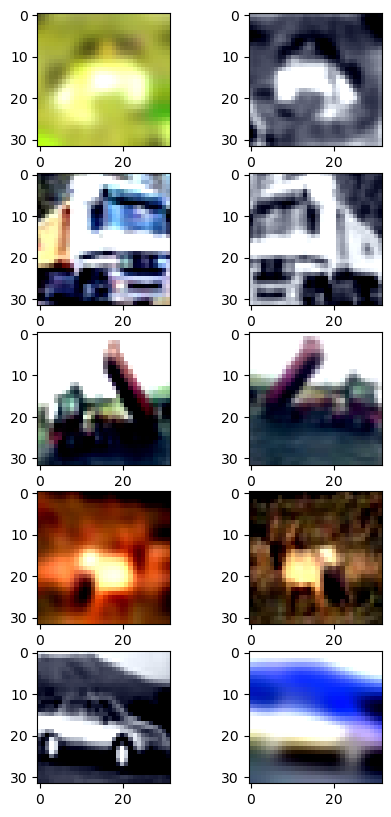

In [ ]:
from matplotlib import pyplot as plt

def convert_to_image(arr):
    arr = np.transpose(arr, (1, 2, 0))
    arr = (arr + 1) / 2
    return np.clip(arr, 0, 1)

num_samples = 5

fig = plt.figure(figsize=(5, 2*num_samples))
for i in range(num_samples):
    x_aug1, x_aug2 = train_unlabeled_loader.dataset[i]
    ax = fig.add_subplot(num_samples, 2, 2 * i + 1)
    ax.imshow(convert_to_image(x_aug1))
    ax = fig.add_subplot(num_samples, 2, 2 * i + 2)
    ax.imshow(convert_to_image(x_aug2))

fig.show()

# Final Section Part 1: Run the experiment under SETTING 1!

### Supervised training on 100 labeled training images.

In [ ]:
from sklearn.metrics import accuracy_score

torch.manual_seed(10)
random.seed(10)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)

model_setting1 = ConvNet()
model_setting1.to(device)

# loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_setting1.parameters(), lr=1e-3)

# training and backpropagation loop
epochs = 50
train_loss_list, train_acc_list = [], []

for i in range(epochs):

    train_loss_epoch = 0
    y_true_arr, y_pred_arr = None, None

    for (x_train, y_train) in train_labeled_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)

        bs = x_train.shape[0]

        y_pred = model_setting1.forward(x_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.cpu().detach().numpy() * bs

        if y_true_arr is None:
            y_true_arr = y_train.cpu().detach().numpy()
            y_pred_arr = y_pred.cpu().detach().numpy().argmax(axis=1)
        else:
            y_true_arr = np.concatenate((y_true_arr, y_train.cpu().detach().numpy()), axis=0)
            y_pred_arr = np.concatenate((y_pred_arr, y_pred.cpu().detach().numpy().argmax(axis=1)), axis=0)

    train_loss_epoch = train_loss_epoch / len(train_labeled_loader.dataset)
    acc = accuracy_score(y_true_arr, y_pred_arr)

    train_loss_list.append(train_loss_epoch)
    train_acc_list.append(acc)

    if i % 10 == 0:
        print(f'Epoch: {i} Train Loss: {train_loss_epoch}, Accuracy: {acc}')


Using device:  cuda:0
Epoch: 0 Train Loss: 2.4195055961608887, Accuracy: 0.15
Epoch: 10 Train Loss: 0.17557506263256073, Accuracy: 0.94
Epoch: 20 Train Loss: 0.08468706160783768, Accuracy: 0.97
Epoch: 30 Train Loss: 0.017839331179857254, Accuracy: 1.0
Epoch: 40 Train Loss: 0.06783026456832886, Accuracy: 0.96


In [ ]:
test_loss_epoch = 0
y_true_arr, y_pred_arr = None, None

model_setting1.eval()
with torch.no_grad():
    for (x_test, y_test) in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)

        bs = x_test.shape[0]

        y_pred = model_setting1.forward(x_test)
        loss = criterion(y_pred, y_test)

        test_loss_epoch += loss.cpu().detach().numpy() * bs

        if y_true_arr is None:
            y_true_arr = y_test.cpu().detach().numpy()
            y_pred_arr = y_pred.cpu().detach().numpy().argmax(axis=1)
        else:
            y_true_arr = np.concatenate((y_true_arr, y_test.cpu().detach().numpy()), axis=0)
            y_pred_arr = np.concatenate((y_pred_arr, y_pred.cpu().detach().numpy().argmax(axis=1)), axis=0)

test_loss_epoch = test_loss_epoch / len(test_loader.dataset)
test_acc = accuracy_score(y_true_arr, y_pred_arr)

print(f'Test Loss: {test_loss_epoch}, Accuracy: {test_acc}')

Test Loss: 6.132363073730469, Accuracy: 0.2189


### NOTE: you are expected to see some significant overfitting, since the training data is just 100 images.

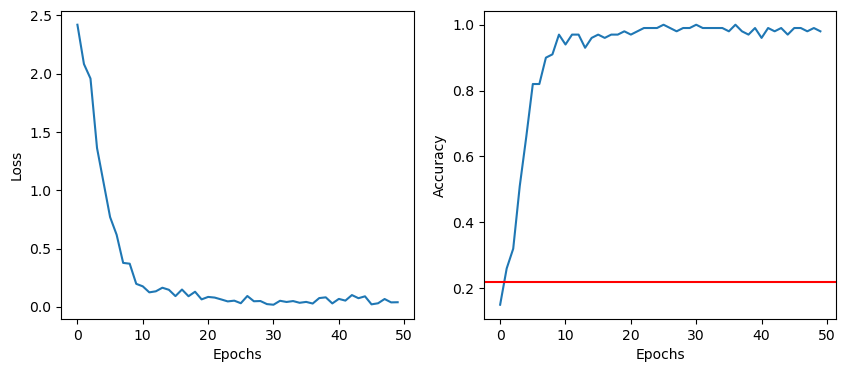

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(epochs), train_loss_list)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(epochs), train_acc_list)
ax.axhline(y=test_acc, color='r')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
fig.show()

# Final Section Part 2: Run the experiment under SETTING 2!

### Contrastive training on 49,900 unlabeled images + Supervised fine-tuning on 100 labeled training images.

Note: We know some of you might not have access to GPU, so we are limiting the training epochs.

For those of you who have GPU access, you can try to increase the epochs for contrastive pre-training.

In [ ]:
from sklearn.metrics import accuracy_score

torch.manual_seed(10)
random.seed(10)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)

model_setting2 = ConvNet()
model_setting2.to(device)

# Step 1. contrastive pre-training.
epochs = 10
criterion_simclr = InfoNCELoss()
optimizer = torch.optim.Adam(model_setting2.parameters(), lr=1e-2)

for i in range(epochs):

    train_loss_epoch, train_pseudoacc_epoch = 0, 0
    for (x_aug1, x_aug2) in train_unlabeled_loader:
        x_aug1, x_aug2 = x_aug1.to(device), x_aug2.to(device)

        bs = x_aug1.shape[0]

        z1 = model_setting2.project(x_aug1)
        z2 = model_setting2.project(x_aug2)

        loss, pseudo_acc = criterion_simclr(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.cpu().detach().numpy() * bs
        train_pseudoacc_epoch += pseudo_acc * bs

    train_loss_epoch = train_loss_epoch / len(train_unlabeled_loader.dataset)
    train_pseudoacc_epoch = train_pseudoacc_epoch / len(train_unlabeled_loader.dataset)

    if i % 4 == 0:
        print(f'Contrastive pre-training epoch: {i} Train Loss: {train_loss_epoch}, Pseudo-Acc: {train_pseudoacc_epoch}')


# Step 2. supervised fine-tuning.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_setting2.parameters(), lr=4e-4)
epochs = 50

train_loss_list, train_acc_list = [], []

for i in range(epochs):

    train_loss_epoch = 0
    y_true_arr, y_pred_arr = None, None

    for (x_train, y_train) in train_labeled_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)

        bs = x_train.shape[0]

        y_pred = model_setting2.forward(x_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.cpu().detach().numpy() * bs

        if y_true_arr is None:
            y_true_arr = y_train.cpu().detach().numpy()
            y_pred_arr = y_pred.cpu().detach().numpy().argmax(axis=1)
        else:
            y_true_arr = np.concatenate((y_true_arr, y_train.cpu().detach().numpy()), axis=0)
            y_pred_arr = np.concatenate((y_pred_arr, y_pred.cpu().detach().numpy().argmax(axis=1)), axis=0)

    train_loss_epoch = train_loss_epoch / len(train_labeled_loader.dataset)
    acc = accuracy_score(y_true_arr, y_pred_arr)

    train_loss_list.append(train_loss_epoch)
    train_acc_list.append(acc)

    if i % 10 == 0:
        print(f'Supervised fine-tuning epoch: {i} Train Loss: {train_loss_epoch}, Accuracy: {acc}')

Using device:  cuda:0


Contrastive pre-training epoch: 0 Train Loss: 4.773734620119145, Pseudo-Acc: 0.5745953626002004
Contrastive pre-training epoch: 4 Train Loss: 4.440497726409851, Pseudo-Acc: 0.5903172751753507
Contrastive pre-training epoch: 8 Train Loss: 4.398286083886523, Pseudo-Acc: 0.5921968937875751
Supervised fine-tuning epoch: 0 Train Loss: 2.329841136932373, Accuracy: 0.13
Supervised fine-tuning epoch: 10 Train Loss: 1.837794303894043, Accuracy: 0.56
Supervised fine-tuning epoch: 20 Train Loss: 1.4588438272476196, Accuracy: 0.67
Supervised fine-tuning epoch: 30 Train Loss: 1.1634091138839722, Accuracy: 0.78
Supervised fine-tuning epoch: 40 Train Loss: 0.9234676957130432, Accuracy: 0.75


In [ ]:
test_loss_epoch = 0
y_true_arr, y_pred_arr = None, None

model_setting2.eval()
with torch.no_grad():
    for (x_test, y_test) in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)

        bs = x_test.shape[0]

        y_pred = model_setting2.forward(x_test)
        loss = criterion(y_pred, y_test)

        test_loss_epoch += loss.cpu().detach().numpy() * bs

        if y_true_arr is None:
            y_true_arr = y_test.cpu().detach().numpy()
            y_pred_arr = y_pred.cpu().detach().numpy().argmax(axis=1)
        else:
            y_true_arr = np.concatenate((y_true_arr, y_test.cpu().detach().numpy()), axis=0)
            y_pred_arr = np.concatenate((y_pred_arr, y_pred.cpu().detach().numpy().argmax(axis=1)), axis=0)

test_loss_epoch = test_loss_epoch / len(test_loader.dataset)
test_acc = accuracy_score(y_true_arr, y_pred_arr)

print(f'Test Loss: {test_loss_epoch}, Accuracy: {test_acc}')

Test Loss: 1.929951816177368, Accuracy: 0.3145


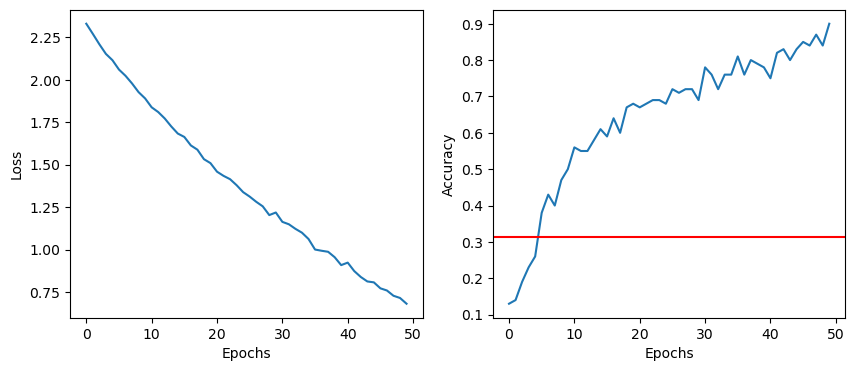

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(epochs), train_loss_list)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(epochs), train_acc_list)
ax.axhline(y=test_acc, color='r')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
fig.show()